# Bayesian Statistics for Physicists: 02 Bayesian Basics

## Contents of the BSFP series

<ul>
    <li><a href="BSFP_01_Overview_and_setup.ipynb">01 Overview and Setup</a>
    <li><a href="BSFP_02_Basics.ipynb">02 Bayesian basics</a>
    <li><a href="BSFP_03_Choosing_priors.ipynb">03 Choosing priors</a>
    <li><a href="BSFP_04_Bayesian_updating.ipynb">04 Examples of Bayesian updating</a>
    <li><a href="BSFP_05_Sampling.ipynb">05 Sampling</a>
    <li><a href="BSFP_06_Model_selection_and_mixing.ipynb">06 Model selection, mixing, ...</a>
    <li><a href="BSFP_07_Gaussian_processes.ipynb">07 Gaussian processes</a>
    <li><a href="BSFP_08_Machine_learning.ipynb">08 Machine learning</a>
    <li><a href="BSFP_A01_Appendices.ipynb">A01 Appendices: reference, vocabulary, notation</a>
</ul>

<hr>

## <a name="Overview">Overview of Bayesian basics</a>

* [Bayes in the sky: Bayesian inference and model selection in cosmology](https://www.tandfonline.com/doi/abs/10.1080/00107510802066753)
* another list item

This is a highly selected summary of some basic topics in Bayesian statistics.
For a more thorough introduction we recommend these physicist-friendly references:

* R. Trotta, [*Bayes in the sky: Bayesian inference and model selection in cosmology*](https://www.tandfonline.com/doi/abs/10.1080/00107510802066753), Contemp. Phys. **49**, 71 (2008)  [arXiv:0803.4089](https://arxiv.org/abs/0803.4089).
        
* D.S. Sivia and J. Skilling, [*Data Analysis: A Bayesian Tutorial, 2nd edition*]("https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320/ref=mt_paperback?_encoding=UTF8&me=&qid="), (Oxford University Press, 2006).
    
* P. Gregory,
     [*Bayesian Logical Data Analysis for the Physical Sciences: A Comparative Approach with Mathematica® Support*]("https://www.amazon.com/Bayesian-Logical-Analysis-Physical-Sciences/dp/0521150124/ref=sr_1_1?s=books&ie=UTF8&qid=1538587731&sr=1-1&keywords=gregory+bayesian"), (Cambridge University Press, 2010).


Last revised: 15-Apr-2019 by Dick Furnstahl [furnstahl.1@osu.edu].


## <a name="Contents">Contents of this notebook on Bayesian basics</a> 

<ul>
    <li><a href="#Python">Python/Jupyter set up</a>
    <li><a href="#Rules">Rules</a>
    <li><a href="#Networks">Networks</a>
    <li><a href="#Discrepancy">Model discrepancy</a> 
</ul>

<hr>

## <a name="Python">Python/Jupyter set up</a>

See <a href="BSFP_01_Overview_and_setup.ipynb">Part 01</a> for overall installation and setup.

In [1]:
# set up for plots in this notebook using matplotlib (there are other plotting choices)
%matplotlib inline   

In [2]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt
#plt.style.use('seaborn') # pretty matplotlib plots

import corner
import pymc3 as pm


In [3]:
# make font adjustments
#plt.rcParams['font.size'] = 12
#plt.rcParams['legend.fontsize'] = 'medium'
#plt.rcParams['figure.titlesize'] = 'medium'
plt.rcdefaults()  # revert to defaults for now

In [4]:
%%html  
<!-- Use html cell magic to add css styling -->
<style>
  em {
      color: red;
  }
  dd {
      margin-left: 15px;
  }
  .red{color: red}
  .blue{color: blue}
  .alphalist{list-style-type: lower-alpha;}
</style>

## <a name="Basics">Bayesian basics</a>

### Why should physicists use Bayesian statistics?

Here are some reasons,  cf. <a href="https://www.astro.princeton.edu/~strauss/AST303/bayesian_paper.pdf">Why isn't every physicist a Bayesian?</a> from 1995. In those days there weren't so many physicists on the Bayes bandwagon!

<ol class="alphalist">
   <li>Update expectations using Bayes’ theorem when more information is available.
   <li>Includes conventional physics statistics (e.g., for parameter estimation).
   <li>Calculate what you really want, e.g., probability for some parameter value vs. frequentist confidence interval.
   <li>Assumptions are made explicit (in the form of priors).
   <li>Allows us to account for "nuisance parameters".
   <li>Clear prescription for combining different types of errors. 
   <li>Well suited for theory errors ("model discrepancy"), which are generally systematic.  Modeling theoretical discrepancy is generally needed to extract true parameter values.
   <li>Model selection: compare different theoretical models (or combine them!).
   <li>Model checking: we can test if our UQ (uncertainty quantification) model works and study sensitivities.
    <li><em>Enables statistics as diagnostic and discovery tools for physics.</em>
    <li> <b>[add your own favorite reasons]</b>
</ol>
We'll elaborate on these points as we go.

### Everything is a pdf (probability density function)

Physicists are used to multidimensional normalized pdfs as wave functions squared, e.g. probability density for particle 1 at $x_1$ and particle 2 at $x_2$:

<span class="red">
 $$
 |\Psi(x_1, x_2)|^2 \Longrightarrow p(x_1,x_2) \equiv p(\textbf{x})  
   \quad \mbox{with}\quad \textbf{x} 
 \equiv \{x_1,x_2\}
 $$
</span> 

(Other notation for generic pdfs: $p(\textbf{x}) = P(\textbf{x}) = \textrm{pr}(\textbf{x}) = \textrm{prob}(\textbf{x}) = \ldots$ )

$p(x_1,x_2)$ is the <em>joint probability density</em> of $x_1$ and $x_2$. <br>
What is the probability to find particle 1 at $x_1$ and particle 2 anywhere?  $\color{blue}{\int\! |\Psi(x_1,x_2)|^2 dx_2}$ (integrated over the full domain of $x_2$, e.g., 0 to $\infty$).<br>
The <em>marginal probability density</em> of $x_1$ is: 
$\color{blue}{p(x_1) = \int\! p(x_1,x_2)\,dx_2}$. <br>
"Marginalizing" = "integrating out" (eliminates "nuisance parameters" from posterior).  

Just as with "Lagrangian", we physicists will not always be careful about saying probability vs. probability density.

In Bayesian statistics there are pdfs (or pmfs if discrete) for data, experimental <i>and</i> theoretical uncertainties, fit parameters, hyperparameters (what?), events (Will it rain tomorrow?), etc.  Even if $x$ has the definite value $x_0$, we can use $p(x) = \delta(x-x_0)$.  


### Visualization of pdfs

#### Matplotlib plotting definitions

In [5]:
def dist_stuff(dist):
    """
    Find the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (from scipy.stats).
    """
    median = [dist.median(), dist.pdf(dist.median())]
    mean = [dist.mean(), dist.pdf(dist.mean())]
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

def dist_mode(dist, x):
    """
    Find the mode (maximum) of the 1-d distribution.
    """
    x_max_index = dist.pdf(x).argmax()
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

def dist_plot(dist_label, x_dist, dist, plot_num):
    """
    Plot the distribution, indicating median, mean, mode
    and 68%/95% probability intervals.
    """
    colors = ('blue', 'blue', 'blue')
    median, mean, cred68, cred95 = dist_stuff(dist)
    mode = dist_mode(dist, x_dist)
    
    plt.subplot(1,3,plot_num)
    plt.plot(x_dist,dist.pdf(x_dist), 
             label=dist_label, color=colors[plot_num-1])
    text_x = 0.2*(x_dist[-1]-x_dist[0])
    text_x_mid = (x_dist[-1]+x_dist[0])/2
    text_y = mode[1]*1.15
    plt.annotate('median', xy=median, xytext=(text_x_mid+text_x, text_y),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('mode', xy=mode, xytext=(text_x_mid-text_x, text_y),
                 arrowprops=dict(facecolor='red', shrink=0.05))
    plt.annotate('mean', xy=mean, xytext=(text_x_mid, text_y),
                 arrowprops=dict(facecolor='blue', shrink=0.05))
    plt.xlabel('x')
    plt.ylabel('p(x)')
    plt.fill_between(x_dist, 0, dist.pdf(x_dist), 
                 where=((x_dist > cred68[0]) & (x_dist < cred68[1])), 
                 facecolor='blue', alpha=0.2)
    plt.fill_between(x_dist, 0, dist.pdf(x_dist), 
                 where=((x_dist > cred95[0]) & (x_dist < cred95[1])), 
                 facecolor='blue', alpha=0.1)
    plt.legend();



#### Some standard pdfs: normal and beta distributions

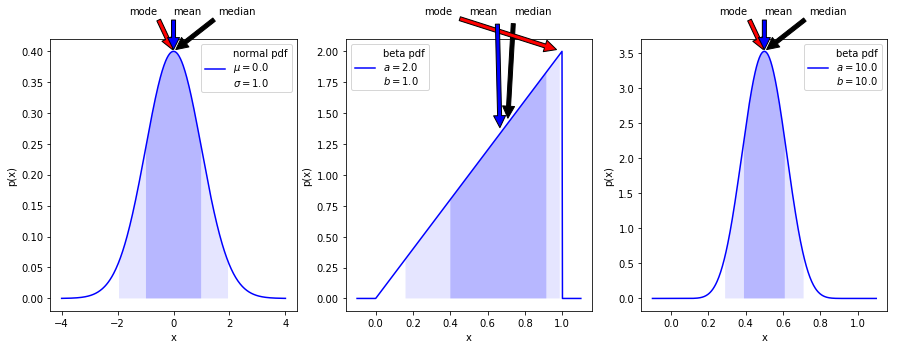

In [6]:
%matplotlib inline

# Make some standard plots
plt.figure(figsize=(15,5))

# Standard normal distribution -- try changing the mean and std. dev. 
x_norm = np.linspace(-4, 4, 500)
mu = 0       # mean
sigma = 1.0  # standard deviation
norm_dist = stats.norm(mu, sigma) # the normal distribution from stats
norm_label='normal pdf' + '\n' + rf'$\mu=${mu:1.1f}' \
             + '\n' + rf'$\sigma=${sigma:1.1f}' 
dist_plot(norm_label, x_norm, norm_dist, 1)

# beta distribution
x_beta = np.linspace(-0.1, 1.1, 500)
a1 = 2
b1 = 1
beta_dist = stats.beta(a1, b1)
beta1_label='beta pdf' + '\n' + rf'$a=${a1:1.1f}' \
              + '\n' + rf'$b=${b1:1.1f}'
dist_plot(beta1_label, x_beta, beta_dist, 2)

# another beta distribution
#x_beta = np.linspace(-0.1, 1.1, 500)
a2 = 10
b2 = 10
beta2_dist = stats.beta(a2, b2)
beta2_label='beta pdf' + '\n' + rf'$a=${a2:1.1f}' \
              + '\n' + rf'$b=${b2:1.1f}' 
dist_plot(beta2_label, x_beta, beta2_dist, 3)


The 68%/95% probability regions are shown in dark/light shading.  When applied to Bayesian posteriors, these are known as <em>credible intervals</em> or DoBs (degree of belief intervals) or Bayesian confidence intervals. The horizontal extent on the $x$-axis translates into the vertical extent of the error bar or error band for $x$.


#### More standard pdfs:  Student t

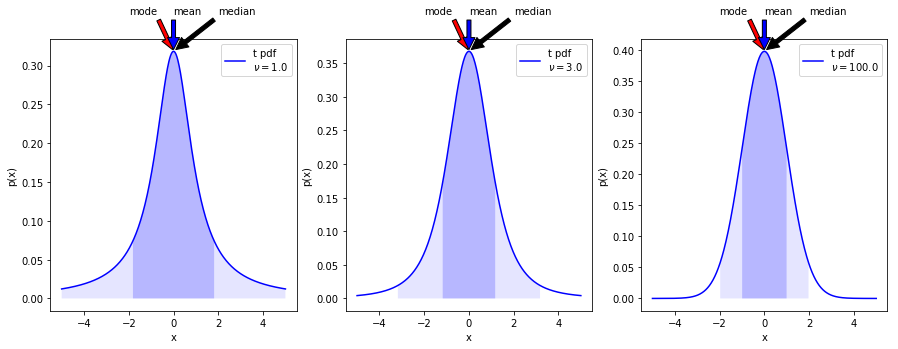

In [7]:
%matplotlib inline

# Make some plots of the Student t distribution
plt.figure(figsize=(15,5))

x_t = np.linspace(-5, 5, 500)

nu1 = 1
t1_dist = stats.t(nu1) # the Student t distribution
t1_label='t pdf' + '\n' + rf'$\nu=${nu1:1.1f}'
dist_plot(t1_label, x_t, t1_dist, 1)

nu2 = 3
t2_dist = stats.t(nu2) # the Student t distribution
t2_label='t pdf' + '\n' + rf'$\nu=${nu2:1.1f}'
dist_plot(t2_label, x_t, t2_dist, 2)

nu3 = 100
t3_dist = stats.t(nu3) # the Student t distribution
t3_label='t pdf' + '\n' + rf'$\nu=${nu3:1.1f}'
dist_plot(t3_label, x_t, t3_dist, 3)


Note the "heavy tails" in the t distribution as $\nu$ gets small.  As $\nu$ gets large, the distribution approaches a standard normal (Gaussian) distribution.

#### Projected posterior plots

Here we use the [corner package](https://corner.readthedocs.io/en/latest/api.html) to make some projected posterior plots.

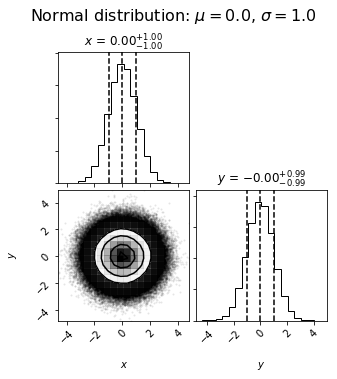

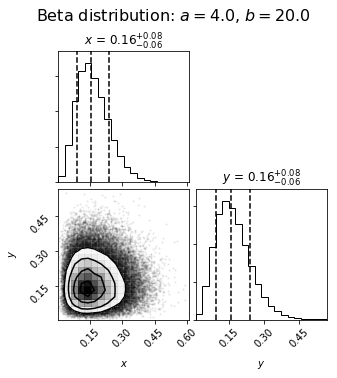

In [8]:
%matplotlib inline
# examples of corner plots
ndim, nsamples = 2, 1000000
#np.random.seed(42)
# generate some synthetic data from a normal distribution
mu, sigma = 0., 1.
norm_samples = stats.norm.rvs(size=ndim * nsamples).reshape([nsamples, ndim])
#figure = corner.corner(norm_samples)
figure1 = corner.corner(norm_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
ax = figure1.get_axes()
my_suptitle = rf'Normal distribution: $\mu = {mu:.1f}$, ' + \
              rf'$\sigma = {sigma:.1f}$'
figure1.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure1.set_size_inches(5,5)


ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some synthetic data from a beta distribution
a = 4
b = 20
beta_samples = stats.beta(a,b).rvs(size=ndim * nsamples) \
                              .reshape([nsamples, ndim])
#figure = corner.corner(beta_samples)
figure2 = corner.corner(beta_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
my_suptitle = rf'Beta distribution: $a = {a:.1f}$, $b = {b:.1f}$'
figure2.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure2.set_size_inches(5,5)


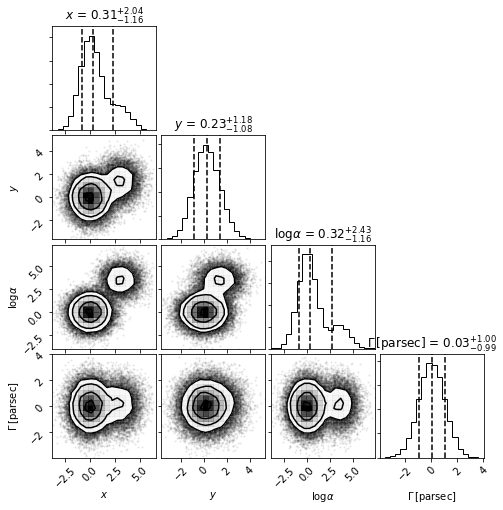

In [9]:
%matplotlib inline
# now more than one mode (all random)
ndim, nsamples = 4, 50000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5) \
          .reshape([4 * nsamples // 5, ndim])
mean = 4*np.random.rand(ndim)
data2 = (mean[None, :] + np.random.randn(ndim * nsamples // 5) \
          .reshape([nsamples // 5, ndim]))
samples = np.vstack([data1, data2])

#figure = corner.corner(samples)
figure = corner.corner(samples, labels=[r"$x$", r"$y$", r"$\log \alpha$", \
                                        r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

figure.set_size_inches(7,7)


### Sampling of 1d pdfs in Python

Here we show how histogrammed samples become closer to the continuous pdf as the sample size increases.

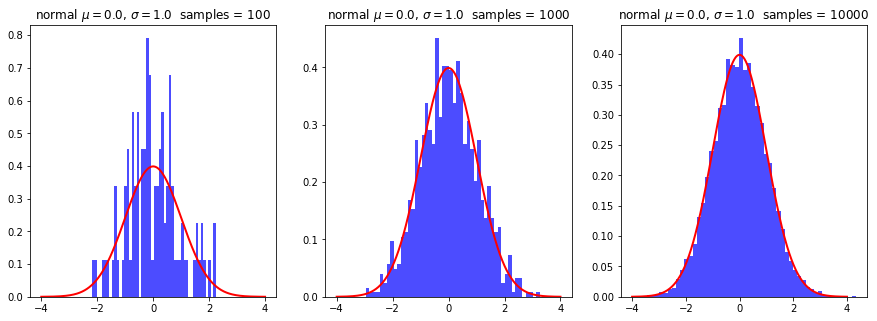

In [10]:
%matplotlib inline

def plot_hist(ax, name, x_dist, dist, num_samples, num_bins):
    """Plot a pdf and a histogram of samples"""
    samples = dist.rvs(size=num_samples)
    count, bins, ignored = ax.hist(samples, num_bins, density=True,
                                     color='blue', alpha=0.7)
    ax.plot(x_dist,dist.pdf(x_dist), linewidth=2, color='r')
    title_string = name + f'  samples = {num_samples:d}'
    ax.set_title(title_string)
    

mu, sigma = 0, 1.0 # mean and standard deviation
x_dist = np.linspace(-4, 4, 500)
name = rf'normal $\mu=${mu:1.1f}, $\sigma=${sigma:1.1f}'
fig = plt.figure(figsize=(15,5))
num_bins = 50

num_samples = 100
norm_dist = stats.norm(mu, sigma)
ax_1 = fig.add_subplot(1, 3, 1)
plot_hist(ax_1, name, x_dist, norm_dist, num_samples, num_bins)

num_samples = 1000
norm_dist = stats.norm(mu, sigma)
ax_2 = fig.add_subplot(1, 3, 2)
plot_hist(ax_2, name, x_dist, norm_dist, num_samples, num_bins)

num_samples = 10000
norm_dist = stats.norm(mu, sigma)
ax_3 = fig.add_subplot(1, 3, 3)
plot_hist(ax_3, name, x_dist, norm_dist, num_samples, num_bins)


<hr>

### Bayes' Rule: Interaction of prior and likelihood

$A$ and $B$ are generic propositions and $I$ is "information" (things we know).  $p(A \mid B)$ means the probability of $A$ given $B$ (or <em>contingent</em> or <em>conditional</em> on $B$). 

A particular case is a vector of parameters $\textbf{a} = \{a_1, a_2, \cdots\}$ for a theoretical model and some data it describes. Here Bayes' Rule is being used for <em>parameter estimation</em>.

$$
  \newcommand{\avec}{\textbf{a}}
  p(A \mid B,I) = 
        \frac{p(B \mid A,I)\, p(A \mid I)}{p(B \mid I)}
  \ \Longrightarrow\ 
   \overbrace{p(\avec \mid \textrm{data},I)}^{\textrm{posterior}} =
  \frac{\color{red}{\overbrace{p(\textrm{data} \mid \avec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{p(\avec \mid I)}^{\textrm{prior}}}}
   {\color{darkgreen}{\underbrace{p(\textrm{data} \mid I)}_{\textrm{evidence}}}}
$$

Common notation in statistics: $\boldsymbol{\theta}$ for parameters, $\mathcal{L}$ or $L$ for the likelihood, $\pi(\boldsymbol{\theta})$ for the prior. 

<hr>

$$\overbrace{p(\avec \mid \textrm{data},I)}^{\textrm{posterior}} \propto \color{red}{\overbrace{p(\textrm{data} \mid \avec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{p(\avec \mid I)}^{\textrm{prior}}}$$

Left: likelihood overwhelms prior.  Right: prior is returned (restricts domain)

<div style="float:left"><img src="figures/Ann_Phys_D1_Cp_abar0_5_k_3_a_1.png" width="250" ></div>
<div style="float:left"><img src="figures/Ann_Phys_D1_Cp_abar0_5_k_3_a_3.png" width="250"></div>
<div style="clear: both"></div>

Note: these are one-dimensional projections of multi-dimensional pdfs.  <br>
<em>Here we don't need to calculate the evidence separately; just normalize the numerator.</em>

<hr>

### Bayesian rules of probability as principles of logic 

Notation: $p(x \mid I)$ is the probability (or pdf) of $x$ being true
given information $I$

1. **Sum rule:** If set $\{x_i\}$ is exhaustive and exclusive, 
  $$ \sum_i p(x_i  \mid  I) = 1   \quad \longrightarrow \quad       \color{red}{\int\!dx\, p(x \mid I) = 1} 
  $$ 
    * cf. complete and orthonormal 
    * implies *marginalization* (cf. inserting complete set of states or integrating out variables)
  $$
   p(x \mid  I) = \sum_j p(x,y_j \mid I) 
    \quad \longrightarrow \quad
   \color{red}{p(x \mid I) = \int\!dy\, p(x,y \mid I)} 
  $$
   
  
2. **Product rule:** expanding a joint probability of $x$ and $y$         
     $$
         \color{red}{ p(x,y \mid I) = p(x \mid y,I)\,p(y \mid I)
              = p(y \mid x,I)\,p(x \mid I)}
     $$

    * If $x$ and $y$ are <em>mutually independent</em>:  $p(x \mid y,I)
      = p(x \mid I)$, then        
    $$
       p(x,y \mid I) \longrightarrow p(x \mid I)\,p(y \mid I)
    $$
    * Rearranging the second equality yields <em> Bayes' Rule (or Theorem)</em>
     $$
      \color{blue}{p(x  \mid y,I) = \frac{p(y \mid x,I)\, 
       p(x \mid I)}{p(y \mid I)}}
     $$

See <a href="https://www.amazon.com/Algebra-Probable-Inference-Richard-Cox/dp/080186982X/ref=sr_1_1?s=books&ie=UTF8&qid=1538835666&sr=1-1">Cox</a> for the proof.

### Bayesian model checking: one example

<span class="red">How can you evaluate whether your Bayesian predictions are working?</span>  
Cf. checking whether a least-squares fit to data with  Gaussian noise misses about 1/3 of your 1-$\sigma$ error bars.
More generally: are the residuals normally distributed?

<em>Are your Bayesian credible intervals consistent with observed successes?</em> Check with a <em>calibration</em> or <em>empirical coverage</em> or <em>credible interval diagnostic</em> plot.

<div style="float:left"><img src="figures/VelocityVsTimeFit.png" width="250" ></div>
<div style="float:left"><img src="figures/weather-forecast-accuracy-flipped.png" width="250"></div>
<div style="clear: both"></div>



<span class="blue">To be discussed: other ways to do Bayesian model checking.</span>

### <a name="Netwoks">Networks</a>

A Bayesian network is a graphical model that makes conditional dependence explicit through the edges in a directed graph.  <span class="red">(More on this soon!)</span> 

<div style="float:left"><img src="figures/Bayesian_Network_2.png" width="220"></div>
<div style="float:right"><img src="figures/Bayesian_Network_independent_lecs_2_v4.png" width="350" ></div>
<div style="clear: both"></div>


### <a name="Discrepancy">Model discrepancy</a>

$\newcommand{\yexp}{\textbf{y}_{\rm exp}}$
$\newcommand{\yth}{\textbf{y}_{\rm th}}$
$\newcommand{\ytrue}{\textbf{y}_{\rm true}}$
The main goal of Bayesian parameter estimation is the calculation of a joint posterior pdf for the model parameters given a set of experimental data and any other information we have.  This task begins with a <em>statistical model</em>:
$$ \yexp = \yth + \Delta \yth + \Delta \yexp $$
where $\yexp$ are the experimental measurements of an observable $y$
and $\yth$ are the corresponding theoretical (model) calculations.
In terms of the true results $\ytrue$, we can decompose this as
$$ \yexp = \ytrue + \Delta\yexp\;; \qquad 
   \ytrue = \yth + \Delta\yth  \;.
$$  
The model for the experimental uncertainty $\Delta\yexp$ is usually stochastic noise
$$ \Delta\yexp \sim \mathcal{N}(0,\Sigma_{\rm exp}) $$
with zero mean and $\Sigma_{\rm exp}$ typically uncorrelated (so the covariance matrix is diagonal).  Systematic uncertainties can also be incorporated.  

The "new" feature here is $\Delta\yth$, which is the model discrepancy or model defect.  Its role is to account statistically for the deficiencies of the model.  It could be a truncation error from an expansion or a model of the observed residuals in a set of training data.
By including $\Delta\yth$, we can suppress overfitting and deal with underfitting. 

<p>[Return to <a href="#Contents">Contents</a>]</p>

<hr>